In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('classic')
import seaborn as sns
import zipfile

In [ ]:
zip = zipfile.ZipFile('/content/drive/MyDrive/DarkMatter/open300.h5.zip')
zip.extractall('/content/drive/MyDrive/DarkMatter')


In [ ]:
train = pd.read_hdf('/content/drive/MyDrive/DarkMatter/open300.h5')
train.head()

,TX,TY,X,Y,Z,event_id,signal,data_ind
0,-0.246019,-0.121373,65072.234375,56973.976562,16809.0,-999.0,0.0,291
1,0.123047,-0.065439,59664.562500,52109.480469,51720.0,-999.0,0.0,291
2,-0.205283,0.399395,41562.195312,31229.628906,16809.0,-999.0,0.0,291
3,0.190030,0.193048,70702.101562,16381.242188,53013.0,-999.0,0.0,291
4,0.095238,0.258185,69712.257812,65766.648438,11637.0,-999.0,0.0,291


In [ ]:
zip = zipfile.ZipFile('/content/drive/MyDrive/DarkMatter/test.h5.zip')
zip.extractall('/content/drive/MyDrive/DarkMatter')
test = pd.read_hdf('/content/drive/MyDrive/DarkMatter/test.h5')
test.head()

,TX,TY,X,Y,Z,data_ind
0,0.087240,0.119438,86536.218750,62988.312500,56892.0,0
1,-0.380208,0.198382,93346.765625,58062.937500,14223.0,0
2,-0.348549,-0.099981,66129.578125,23038.673828,46548.0,0
3,0.585342,-0.126879,68825.523438,55186.625000,45255.0,0
4,0.038579,-0.131510,36366.941406,47564.878906,9051.0,0


In [ ]:
train.isnull().sum()

TX          0
TY          0
X           0
Y           0
Z           0
event_id    0
signal      0
data_ind    0
dtype: int64

In [ ]:
train.signal.value_counts()

0.0    6830530
1.0     161647
Name: signal, dtype: int64

In [ ]:
train_signal = train.copy()

In [ ]:
train_signal = train_signal[train['signal']==1]

In [ ]:
train_signal.signal.value_counts()

1.0    161647
Name: signal, dtype: int64

In [ ]:
from mpl_toolkits.mplot3d import Axes3D
CMAP = sns.diverging_palette(220, 20, s=99, as_cmap=True, n=2500)

def plot3D(X, target, elev=0, azim=0, title=None, sub=111):
    x = X[:, 0]
    y = X[:, 1]
    z = X[:, 2]
    
    fig = plt.figure(figsize=(12, 8))
    ax = Axes3D(fig)
    mappab = ax.scatter(x, y, z, c=target, cmap=CMAP)

    if title is not None:
        ax.set_title(title)
    ax.set_xlabel('Component 1')
    ax.set_ylabel('Component 2')
    ax.set_zlabel('Component 3')

    ax.view_init(elev=elev, azim=azim)
    fig.colorbar(mappable=mappab, label='Target variable')
    plt.show()
    
feat_XY = ['TX', 'TY', 'X', 'Y']
first = train.loc[train.data_ind == 291, :]
plot3D(first.loc[first.signal==1, ['Z', 'X', 'Y']].values,first.loc[first.signal==1].signal.values, elev=20, azim=60)

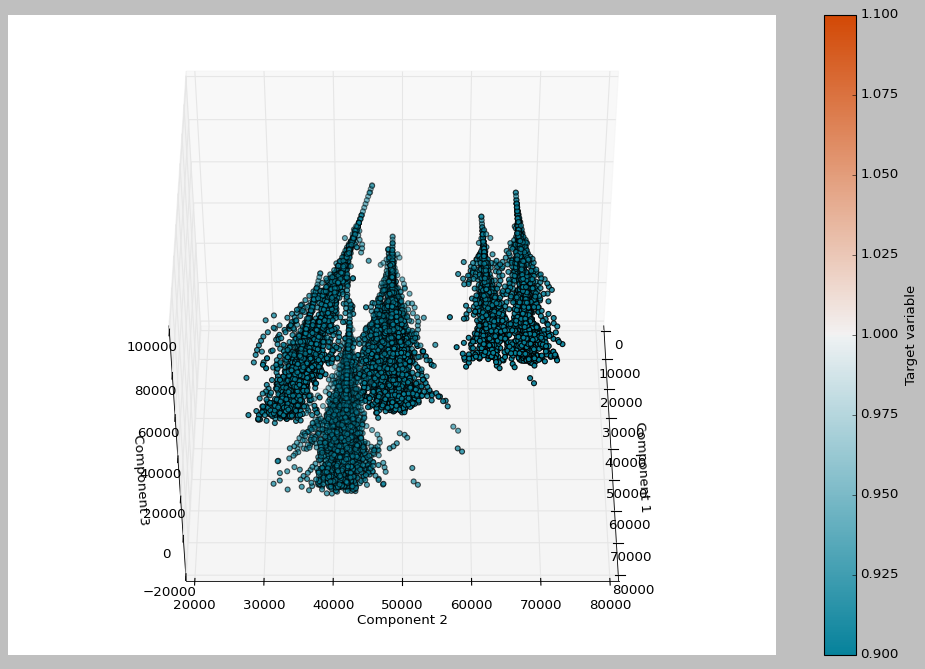

In [ ]:
plot3D(first.loc[first.signal==1, ['Z', 'X', 'Y']].values,
       first.loc[first.signal==1].signal.values, elev=45, azim=0)

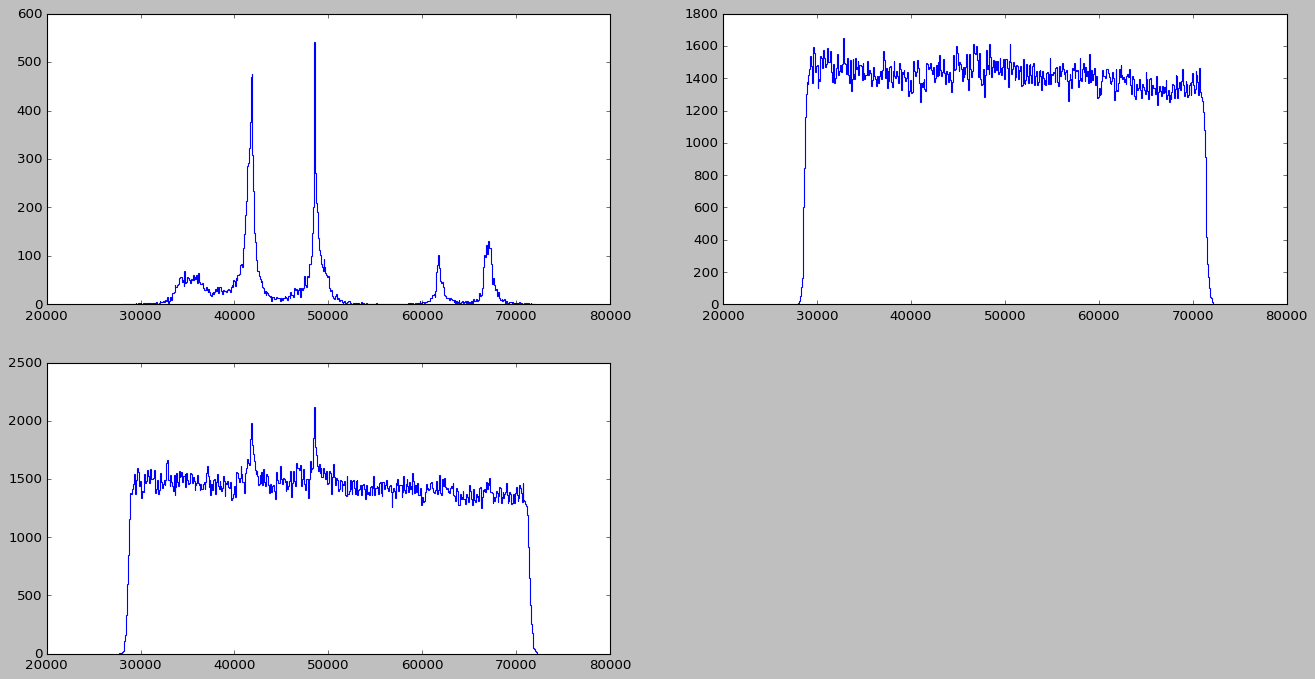

In [ ]:
axis = 'X'

fig = plt.figure(figsize = [20, 10])
fig.add_subplot(221)
plt.hist(first.loc[first.signal == 1, axis], bins=500, histtype='step')
fig.add_subplot(222)
plt.hist(first.loc[first.signal == 0, axis], bins=500, histtype='step')
fig.add_subplot(223)
values_X = plt.hist(first.loc[:, axis], bins=500, histtype='step')
plt.show()

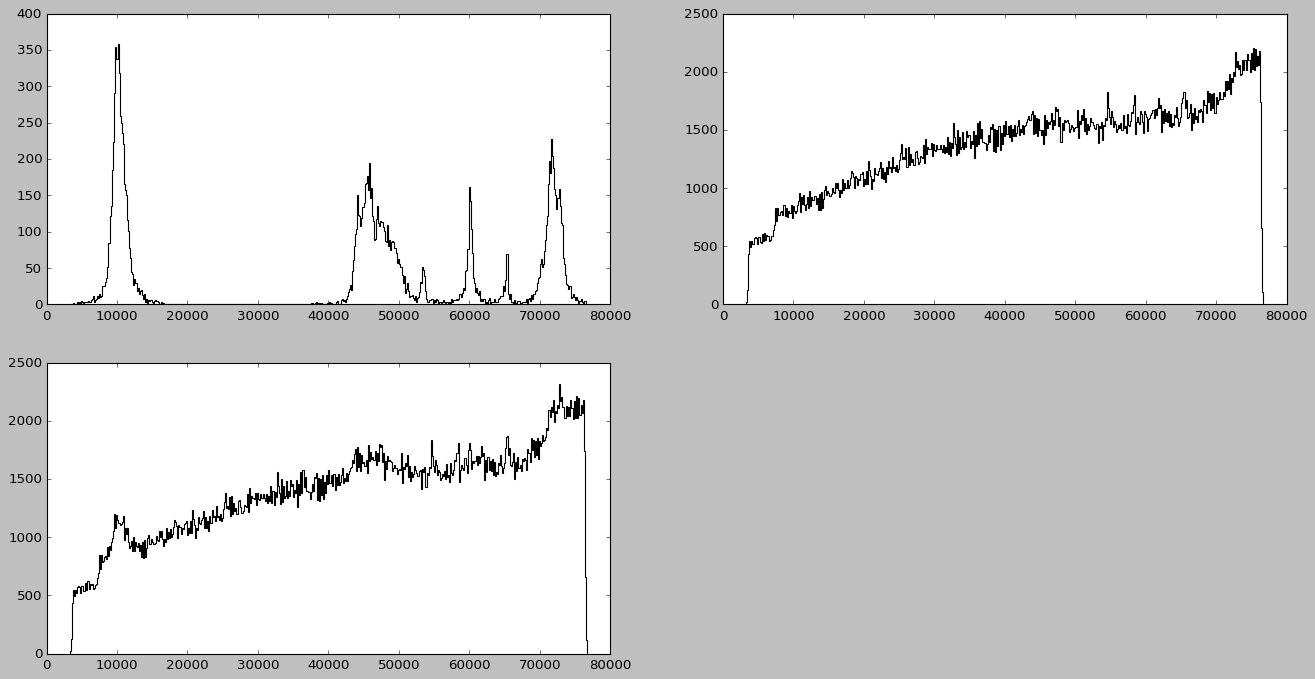

In [ ]:
axis = 'Y'

fig = plt.figure(figsize = [20, 10])
fig.add_subplot(221)
plt.hist(first.loc[first.signal == 1, axis], bins=500, histtype='step', color = 'black')
fig.add_subplot(222)
plt.hist(first.loc[first.signal == 0, axis], bins=500, histtype='step', color = 'black')
fig.add_subplot(223)
values_X = plt.hist(first.loc[:, axis], bins=500, histtype='step', color = 'black')
plt.show()

In [ ]:
axis = 'Z'

fig = plt.figure(figsize = [20, 10])
fig.add_subplot(221)
plt.hist(first.loc[first.signal == 1, axis], bins=500, histtype='step',color = 'green')
fig.add_subplot(222)
plt.hist(first.loc[first.signal == 0, axis], bins=500, histtype='step',color = 'green')
fig.add_subplot(223)
values_X = plt.hist(first.loc[:, axis], bins=500, histtype='step',color = 'green')
plt.show()

In [ ]:
import glob
from tqdm import tqdm
from sklearn.neighbors import BallTree, KDTree, DistanceMetric
def add_neighbours(df, k, metric='minkowski'):
    res = []
    
    for data_ind in tqdm(np.unique(df.data_ind)):
        ind = df.loc[df.data_ind == data_ind].copy()
        ind[['TX', 'TY']] *= 1293
        values = np.unique(ind.Z)
        
        for j in range(1, len(values)):
            z, z_next = (ind.loc[ind.Z == values[j-1]].copy(),
                         ind.loc[ind.Z == values[j]].copy())
            
            b_tree = BallTree(z_next[feat_XY], metric=metric)
            d, i = b_tree.query(z[feat_XY], k=min(k, len(z_next)))
            
            for m in range(i.shape[1]):
                data = z_next.iloc[i[:, m]]
                z_copy = z.copy()
                for col in feat_XY + ['Z']:
                    z_copy[col + '_pair'] = data[col].values
                res.append(z_copy)
            
        res.append(z_next)
        
    res = pd.concat(res)
    for col in feat_XY + ['Z']:
        res['d' + col] = res[col].values - res[col + '_pair'].values
    return res

def balance_train(df, k):
    data = add_neighbours(df, k=k)
    noise = data.event_id == -999
    signal, not_signal = data.loc[np.logical_not(noise)], data.loc[noise]
    noise_part = not_signal.sample(len(signal))
    return pd.concat([signal, noise_part]).reset_index(drop=True)
train = []
for file in glob.glob('/content/drive/MyDrive/DarkMatter/open300.h5')[:5]: # just 5 bricks
    train.append(balance_train(pd.read_hdf(file), k=3))
train = pd.concat(train)

In [ ]:
y_train = train.signal
X_train = train.drop(['event_id', 'signal', 'data_ind'], axis=1)

In [ ]:
from sklearn.preprocessing import Normalizer

In [ ]:
transformer = Normalizer()
X_train_norm = transformer.fit_transform(X_train.fillna(0))

In [ ]:
from sklearn.model_selection import StratifiedKFold, StratifiedShuffleSplit

In [ ]:
sss = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=0)
train_index, val_index = next(sss.split(X_train_norm, y_train))

In [ ]:
from keras.layers.core import Dense, Activation, Dropout
from keras.models import Sequential
from keras.optimizers import Adam
from keras.utils import np_utils
from keras.callbacks import EarlyStopping, ModelCheckpoint


def nn_model(input_dim):
    model = Sequential()
    model.add(Dense(256, input_dim=input_dim))
    model.add(Activation('relu'))
    model.add(Dropout(0.5))
    
    model.add(Dense(128))
    model.add(Activation('relu'))
    model.add(Dropout(0.5))
    
    model.add(Dense(64))
    model.add(Activation('relu'))
    model.add(Dropout(0.5))

    model.add(Dense(1))
    model.add(Activation('sigmoid'))

    model.compile(loss='binary_crossentropy', optimizer=Adam())
    return model

In [ ]:
callbacks = [EarlyStopping(monitor='val_loss', min_delta=0, patience=5, verbose=0, mode='auto'),
            ModelCheckpoint('{val_loss:.4f}.hdf5', monitor='val_loss', verbose=2, save_best_only=True, mode='auto')]

In [ ]:
nn = nn_model(X_train_norm.shape[1])
nn.fit(X_train_norm, y_train, validation_split=0.2, epochs=20, verbose=2, batch_size=256, shuffle=True, callbacks=callbacks)

In [ ]:
prepared_test = add_neighbours(test, k=3)
X_test = prepared_test.drop(['data_ind'], axis=1)

In [ ]:
X_test_norm = transformer.transform(X_test.fillna(0))
X_test = transformer.transform(X_test.fillna(0))

In [ ]:
X_test_norm[:5]

In [ ]:
probas = nn.predict_proba(X_test_norm)
probas = np.squeeze(probas)

In [ ]:
df = pd.DataFrame({'id': prepared_test.index, 'signal': probas}).groupby('id')
agg = df.aggregate(('mean')).loc[:, ['signal']]

In [ ]:
agg.head()

In [ ]:
from sklearn.cluster import KMeans
kmeans_per_k = [KMeans(n_clusters=k, random_state=42).fit(train_signal)
                for k in range(1, 10)]
inertias = [model.inertia_ for model in kmeans_per_k]
k = [inertias.index(i) for i in inertias]

In [ ]:
plt.plot(k, inertias, linewidth=2.0)
line, = plt.plot(k, inertias, 'o')
plt.xlabel("$k$", fontsize=14)
plt.ylabel("Inertia", fontsize=14)

In [ ]:
kmeans = KMeans(n_clusters=6, random_state=42).fit(train_signal)
clustering_labels = kmeans.labels_

In [ ]:
clusters = train_signal
clusters['cluster'] = clustering_labels

In [ ]:
X_sample = train_signal.sample(frac=0.1, random_state=42)
X_sample.head()

,TX,TY,X,Y,Z,event_id,signal,data_ind,cluster
6328232,0.016219,0.025084,46320.863281,20601.740234,32325.0,180065.0,1.0,300,1
1556389,-0.288321,0.138555,30511.503906,33989.488281,38790.0,182666.0,1.0,293,1
4436747,-0.025959,-0.013090,52731.132812,66154.703125,62064.0,198812.0,1.0,297,4
3272,-0.110726,-0.069201,41539.042969,9742.875000,49134.0,184831.0,1.0,291,1
5662327,0.052727,0.039396,36229.804688,63305.679688,50427.0,190482.0,1.0,299,0


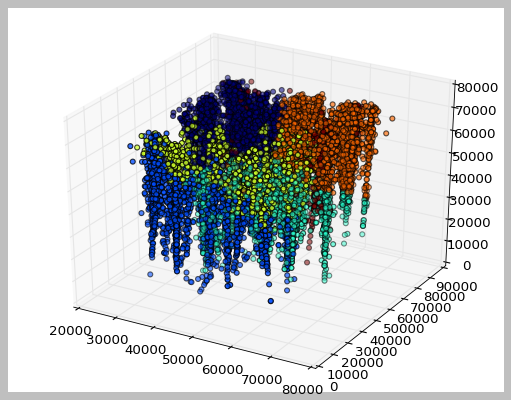

In [ ]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(X_sample.X, X_sample.Y, X_sample.Z, c=X_sample.cluster)

In [ ]:
from xgboost import XGBClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import StratifiedKFold, StratifiedShuffleSplit
param_grid = {
        'n_estimators':[10, 20], 
        'max_depth':[15],
}

class XGBClassifier_tmp(XGBClassifier):
    def predict(self, X):
        return XGBClassifier.predict_proba(self, X)[:, 1]

clf = GridSearchCV(XGBClassifier_tmp(learning_rate=0.05, subsample=0.8,
                                     colsample_bytree=0.8, n_jobs=20), 
                   param_grid=param_grid, n_jobs=3,
                   scoring='roc_auc',
                   cv=StratifiedKFold(3, shuffle=True, random_state=0),
                   verbose=7)
clf.fit(X_train, y_train)

xgb = XGBClassifier_tmp(base_score=0.5, booster='gbtree', colsample_bylevel=1,
         colsample_bytree=0.8, gamma=0, learning_rate=0.05,
         max_delta_step=0, max_depth=15, min_child_weight=1, missing=None,
         n_estimators=100, nthread=None,
         objective='binary:logistic', random_state=0, reg_alpha=0,
         reg_lambda=1, scale_pos_weight=1, seed=None, silent=True,
         subsample=0.8, n_jobs=24)

prepared_test = add_neighbours(test, k=3)
X_test = prepared_test.drop(['data_ind'], axis=1)
xgb_class.fit(X_train, y_train)
probas = xgb_class.predict(X_test)